### Evaluation code for the dataset Bla bla

To address the intensity scale differences between low-SNR inputs and high-SNR groundtruth images in fluorescence microscopy, we used modified versions of PSNR, SSIM, and MS-SSIM that account for these variations:

MicroSSIM & MicroMS-SSIM: Variants of SSIM and MS-SSIM, where predictions are scaled by an optimal scalar. Both the scaled predictions and groundtruth are then normalized before computing the metrics using the original SSIM or MS-SSIM formulas.

CARE-PSNR: A PSNR variant from CARE [ref], where an optimal scaling factor is applied to the predictions, and PSNR is computed between the scaled predictions and the groundtruth.

### Important ! 

This step has to be executed in order to get predictions!

#### General imports

In [1]:
import os
import copy
import pooch
import tifffile
import numpy as np
import matplotlib as mpl
import matplotlib.patches as patches
import matplotlib.pyplot as plt

from microsplit_reproducibility.configs.factory import (
    create_algorithm_config,
    get_likelihood_config,
    get_loss_config,
    get_model_config,
    get_optimizer_config,
    get_training_config,
    get_lr_scheduler_config,
)
from microsplit_reproducibility.utils.io import load_checkpoint
from microsplit_reproducibility.utils.utils import (
    plot_input_patches,
    plot_individual_samples,
)
from microsplit_reproducibility.datasets import create_train_val_datasets

from careamics.lightning import VAEModule
from careamics.lvae_training.eval_utils import (
    get_predictions,
    plot_error,
    get_single_file_predictions,
)
from careamics.utils.metrics import avg_range_invariant_psnr, avg_ssim

#### Experiments specific imports

In [2]:
from microsplit_reproducibility.configs.parameters.HT_LIF24 import get_microsplit_parameters
from microsplit_reproducibility.configs.data.HT_LIF24 import get_data_configs
from microsplit_reproducibility.datasets.HT_LIF24 import get_train_val_data

### Define sub-experiment 

In [3]:
index = "20ms"

### Download the data

In [4]:
DATA = pooch.create(
    path="./data",
    base_url="https://download.fht.org/jug/microsplit/ht_lif24/data",
    registry={"ht_lif24.zip": None},
)

NOISE_MODELS = pooch.create(
    path="./noise_models",
    base_url=f"https://download.fht.org/jug/microsplit/ht_lif24/{index}",
    registry={
        "nm_ht_lif24_ch1_20ms.npz": None,
        "nm_ht_lif24_ch2_20ms.npz": None,
        "nm_ht_lif24_ch3_20ms.npz": None,
    },
)

MODEL_CHECKPOINTS = pooch.create(
    path="./checkpoints",
    base_url=f"https://download.fht.org/jug/microsplit/ht_lif24/{index}",
    registry={"best.ckpt": None, "last.ckpt": None},
)

In [5]:
for i, f in enumerate(NOISE_MODELS.registry):
    NOISE_MODELS.fetch(f"nm_ht_lif24_ch{i+1}_20ms.npz")

DATA.fetch("ht_lif24.zip", processor=pooch.Unzip())

for f in MODEL_CHECKPOINTS.registry:
    MODEL_CHECKPOINTS.fetch(f"{f}")

### Get configs

In [6]:
train_data_config, val_data_config, test_data_configs = get_data_configs(
    dset_type=index
)
experiment_params = get_microsplit_parameters(
    dset_type=index, nm_path=NOISE_MODELS.path
)

### Create dataset

In [7]:
train_dset, val_dset, test_dset, data_stats = create_train_val_datasets(
    datapath=DATA.path / "ht_lif24.zip.unzip/ht_lif24",
    train_config=train_data_config,
    val_config=val_data_config,
    test_config=val_data_config,
    load_data_func=get_train_val_data,
)

Loading from data/ht_lif24.zip.unzip/ht_lif24/Set1/uSplit_20ms.nd2
ND2 dimensions: {'P': 20, 'C': 19, 'Y': 1608, 'X': 1608}; RGB: False; datatype: uint16; legacy: False
Loading from data/ht_lif24.zip.unzip/ht_lif24/Set2/uSplit_20ms.nd2
ND2 dimensions: {'P': 11, 'C': 19, 'Y': 1608, 'X': 1608}; RGB: False; datatype: uint16; legacy: False
Loading from data/ht_lif24.zip.unzip/ht_lif24/Set3/uSplit_20ms.nd2
ND2 dimensions: {'P': 20, 'C': 19, 'Y': 1608, 'X': 1608}; RGB: False; datatype: uint16; legacy: False
Loading from data/ht_lif24.zip.unzip/ht_lif24/Set4/uSplit_20ms.nd2
ND2 dimensions: {'P': 20, 'C': 19, 'Y': 1608, 'X': 1608}; RGB: False; datatype: uint16; legacy: False
Loading from data/ht_lif24.zip.unzip/ht_lif24/Set5/uSplit_20ms.nd2
ND2 dimensions: {'P': 21, 'C': 19, 'Y': 1608, 'X': 1608}; RGB: False; datatype: uint16; legacy: False
Loading from data/ht_lif24.zip.unzip/ht_lif24/Set6/uSplit_20ms.nd2
ND2 dimensions: {'P': 20, 'C': 19, 'Y': 1608, 'X': 1608}; RGB: False; datatype: uint16; 

In [8]:
val_dset.reduce_data([0])

[LCMultiChDloader] Data reduced. New data shape: (1, 1608, 1608, 4)


### Get experiment configs

In [9]:
experiment_params["data_stats"] = data_stats

loss_config = get_loss_config(**experiment_params)
model_config = get_model_config(**experiment_params)
gaussian_lik_config, noise_model_config, nm_lik_config = get_likelihood_config(
    **experiment_params
)
training_config = get_training_config(**experiment_params)
lr_scheduler_config = get_lr_scheduler_config(**experiment_params)
optimizer_config = get_optimizer_config(**experiment_params)

experiment_config = create_algorithm_config(
    algorithm=experiment_params["algorithm"],
    loss_config=loss_config,
    model_config=model_config,
    gaussian_lik_config=gaussian_lik_config,
    nm_config=noise_model_config,
    nm_lik_config=nm_lik_config,
    lr_scheduler_config=lr_scheduler_config,
    optimizer_config=optimizer_config,
)

/home/ashesh.ashesh/mambaforge/envs/microSplit/lib/python3.9/site-packages/careamics/utils/serializers.py:62: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(lst)


### Visualize input data


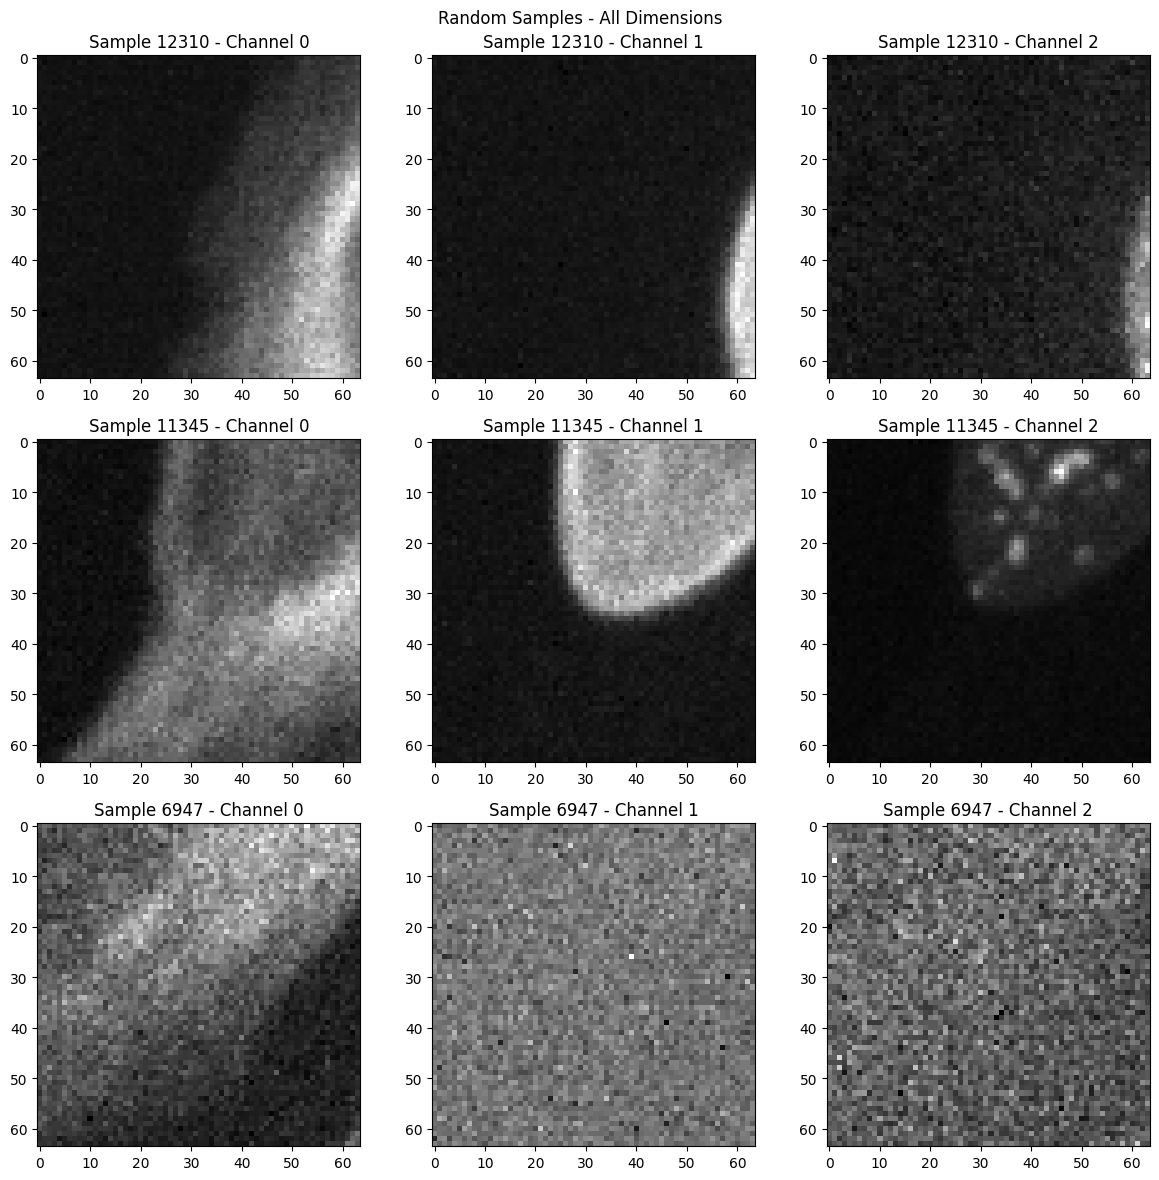

In [10]:
plot_input_patches(dataset=test_dset, num_channels=3, num_samples=3)

### Create model and load checkpoint

In [11]:
model = VAEModule(algorithm_config=experiment_config)

[GaussianMixtureNoiseModel] min_sigma: 0.125
[GaussianMixtureNoiseModel] min_sigma: 0.125
[GaussianMixtureNoiseModel] min_sigma: 0.125
[MultiChannelNoiseModel] Nmodels count:3
[GaussianLikelihood] PredLVar:pixelwise LowBLVar:-5.0


#### Set the model to inference mode
(Optional) 
Change the tile size to reduce the appearance of tiling artifacts. The combination of 
# TODO add explanation

In [12]:
model.model.reset_for_inference(tile_size=[256, 256])

In [13]:
ckpt = load_checkpoint("checkpoints", best=True)

Loading checkpoint from: 'checkpoints/best.ckpt' - Epoch: 394


In [14]:
model.load_state_dict(ckpt["state_dict"], strict=True)

<All keys matched successfully>

### Get samples from the model

Here we display a single sample of one image from the validation dataset.

In [15]:
# Get the random
dataset_subset = copy.deepcopy(test_dset)
sample_idx = np.random.randint(0, dataset_subset._data.shape[0])
dataset_subset._data = dataset_subset._data[sample_idx][None]

In [16]:
# number of samples to plot
num_samples = 2
stitched_samples = []

# You might need to adjust the batch size depending on the available memory
for i in range(num_samples):
    stitched_samples.append(
        get_single_file_predictions(
            model=model,
            dset=dataset_subset,
            tile_size=model.model.image_size,
            batch_size=8,
            num_workers=experiment_params["num_workers"],
        )
    )

Predicting tiles:   0%|          | 0/242 [00:00<?, ?it/s]

Predicting tiles: 100%|██████████| 242/242 [01:20<00:00,  3.01it/s]


### Visualize individual samples

Might create tiling artifacts

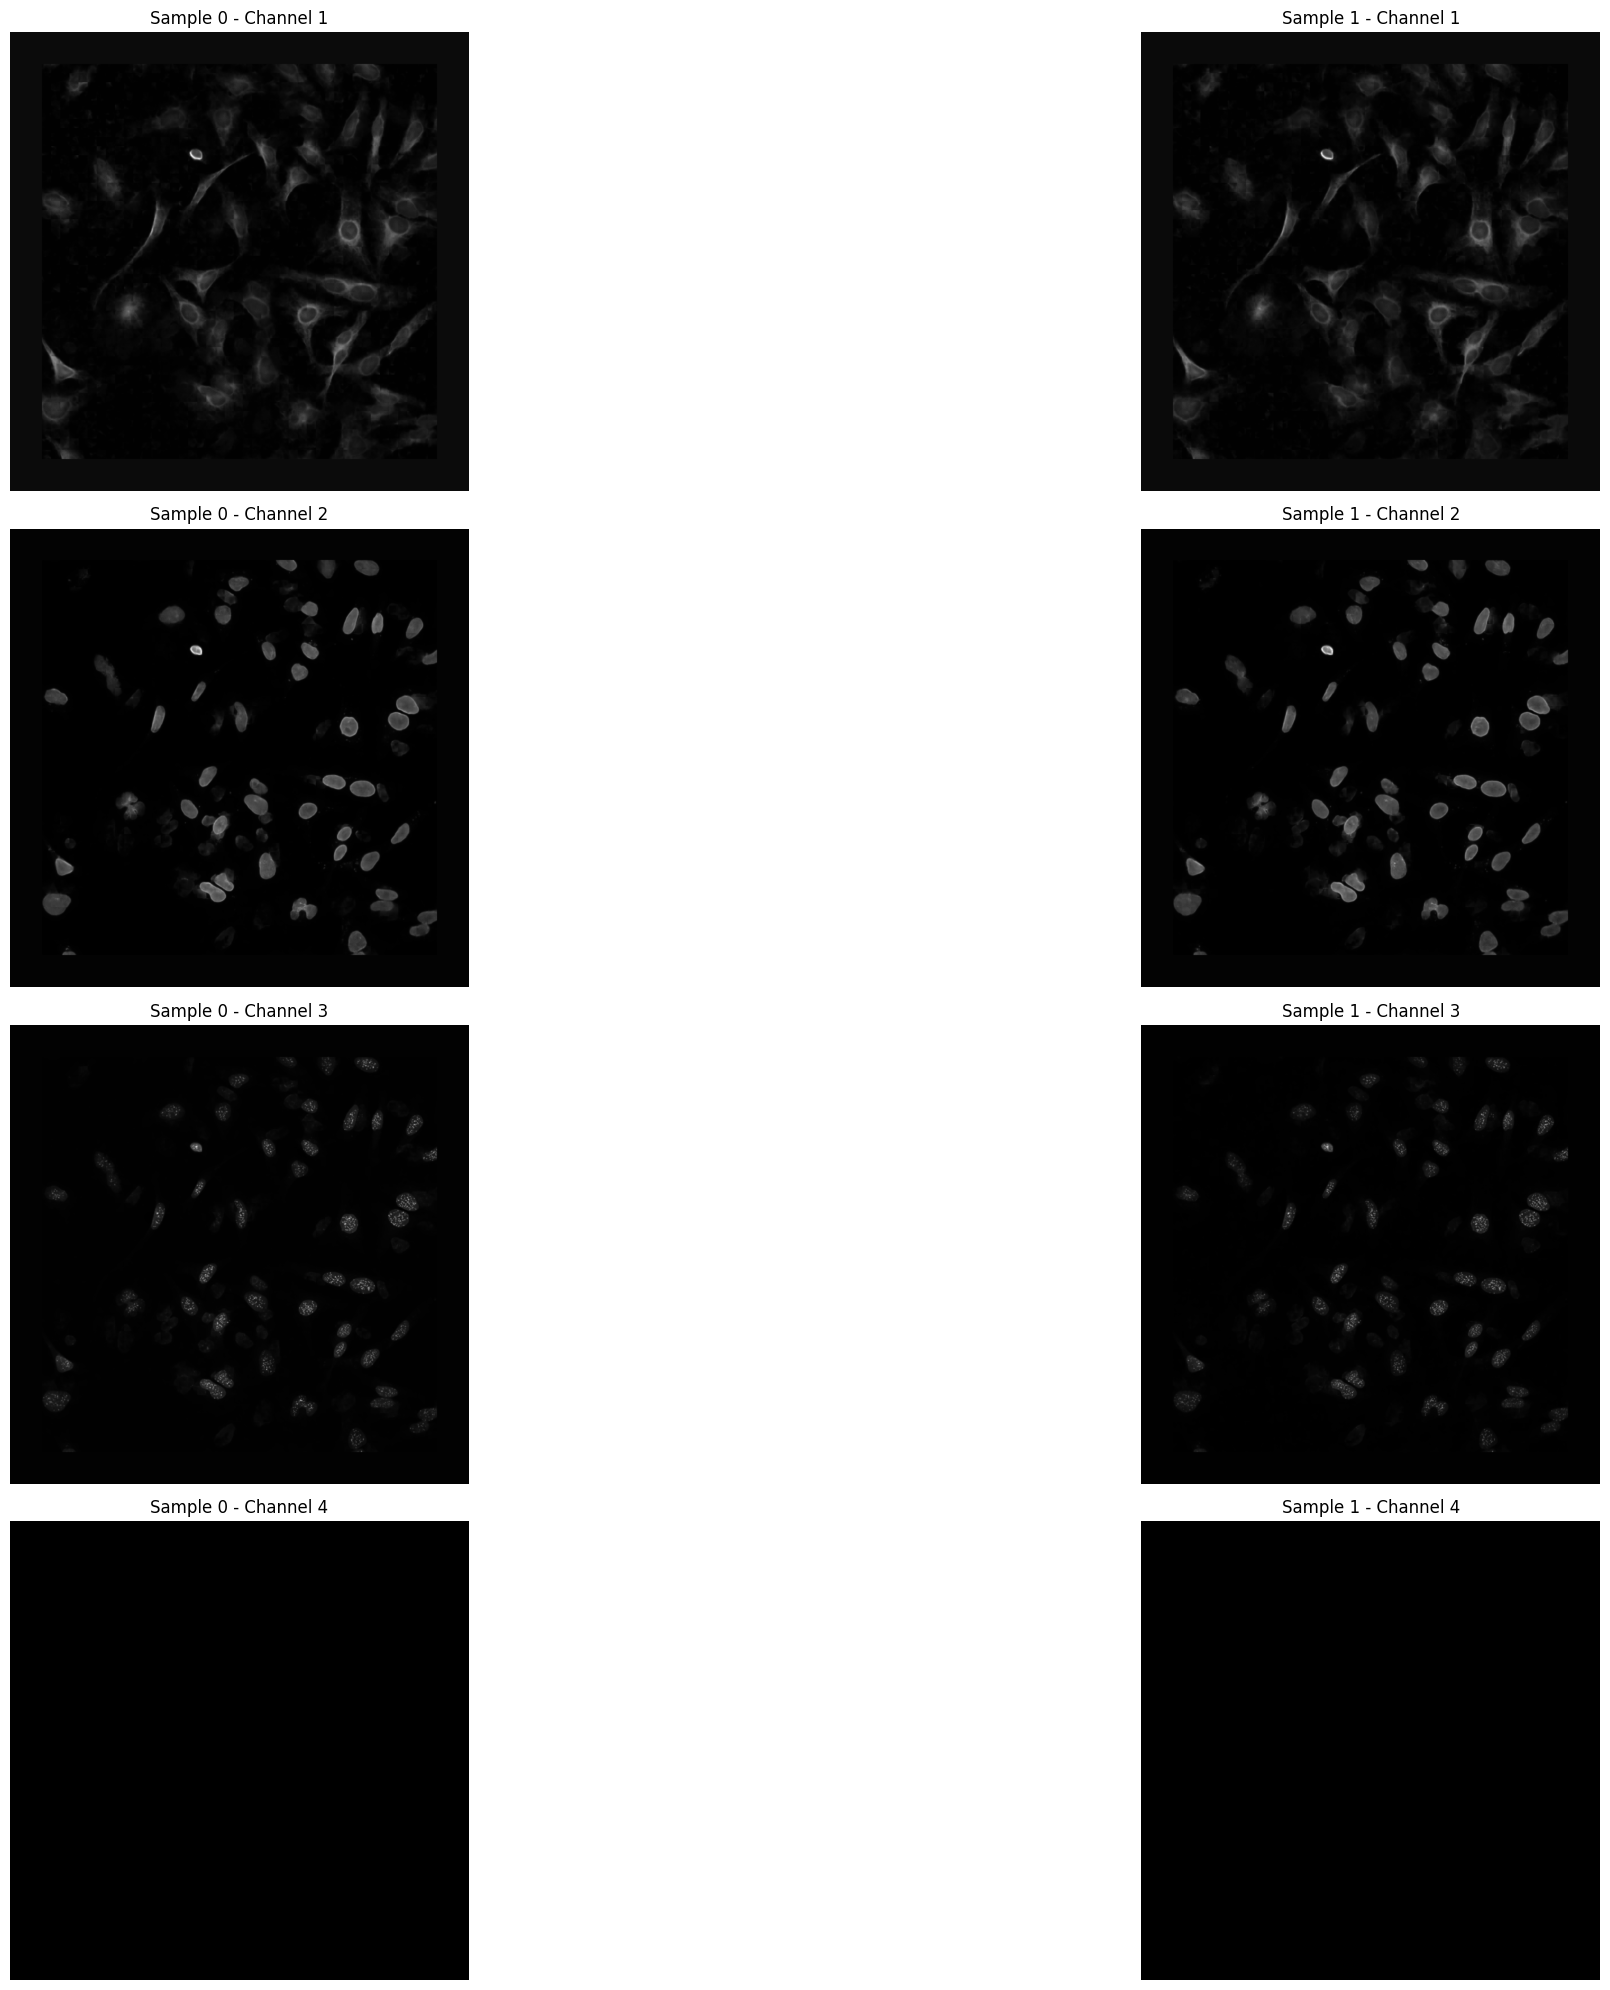

In [17]:
plot_individual_samples(stitched_samples)

### Perform evaluation on the full test dataset

In [18]:
# We might need to reset the input size for computing mmse prediction
model.model.reset_for_inference(tile_size=[64, 64])

In [19]:
# You might need to adjust the batch size depending on the available memory
stitched_predictions, stitched_stds = get_predictions(
    model=model,
    dset=test_dset,
    batch_size=8,
    num_workers=experiment_params["num_workers"],
    mmse_count=2,#experiment_params["mmse_count"],
    tile_size=model.model.image_size,
)

Predicting tiles:   0%|          | 0/3750 [00:00<?, ?it/s]

Predicting tiles: 100%|██████████| 3750/3750 [03:58<00:00, 15.69it/s]


# Prepare the data for metrics calculation

In [20]:
# Filename
filename_idx = str(test_dset._fpath).split("/")[-1].split(".")[0]

target = test_dset._data[..., :-1]
predictions = stitched_predictions[filename_idx][..., :-1]

sep_mean = np.transpose(data_stats[0].numpy(), axes=(0, 2, 3, 1))
sep_std = np.transpose(data_stats[1].numpy(), axes=(0, 2, 3, 1))

target_normalized = (target - sep_mean) / sep_std

In [21]:
pred_unnormalized = []
for i in range(predictions.shape[-1]):
    if sep_std.shape[-1] == 1:
        temp_pred_unnorm = predictions[...,i] * sep_std[...,0] + sep_mean[...,0]
    else:
        temp_pred_unnorm = predictions[...,i] * sep_std[...,i] + sep_mean[...,i]
    pred_unnormalized.append(temp_pred_unnorm)

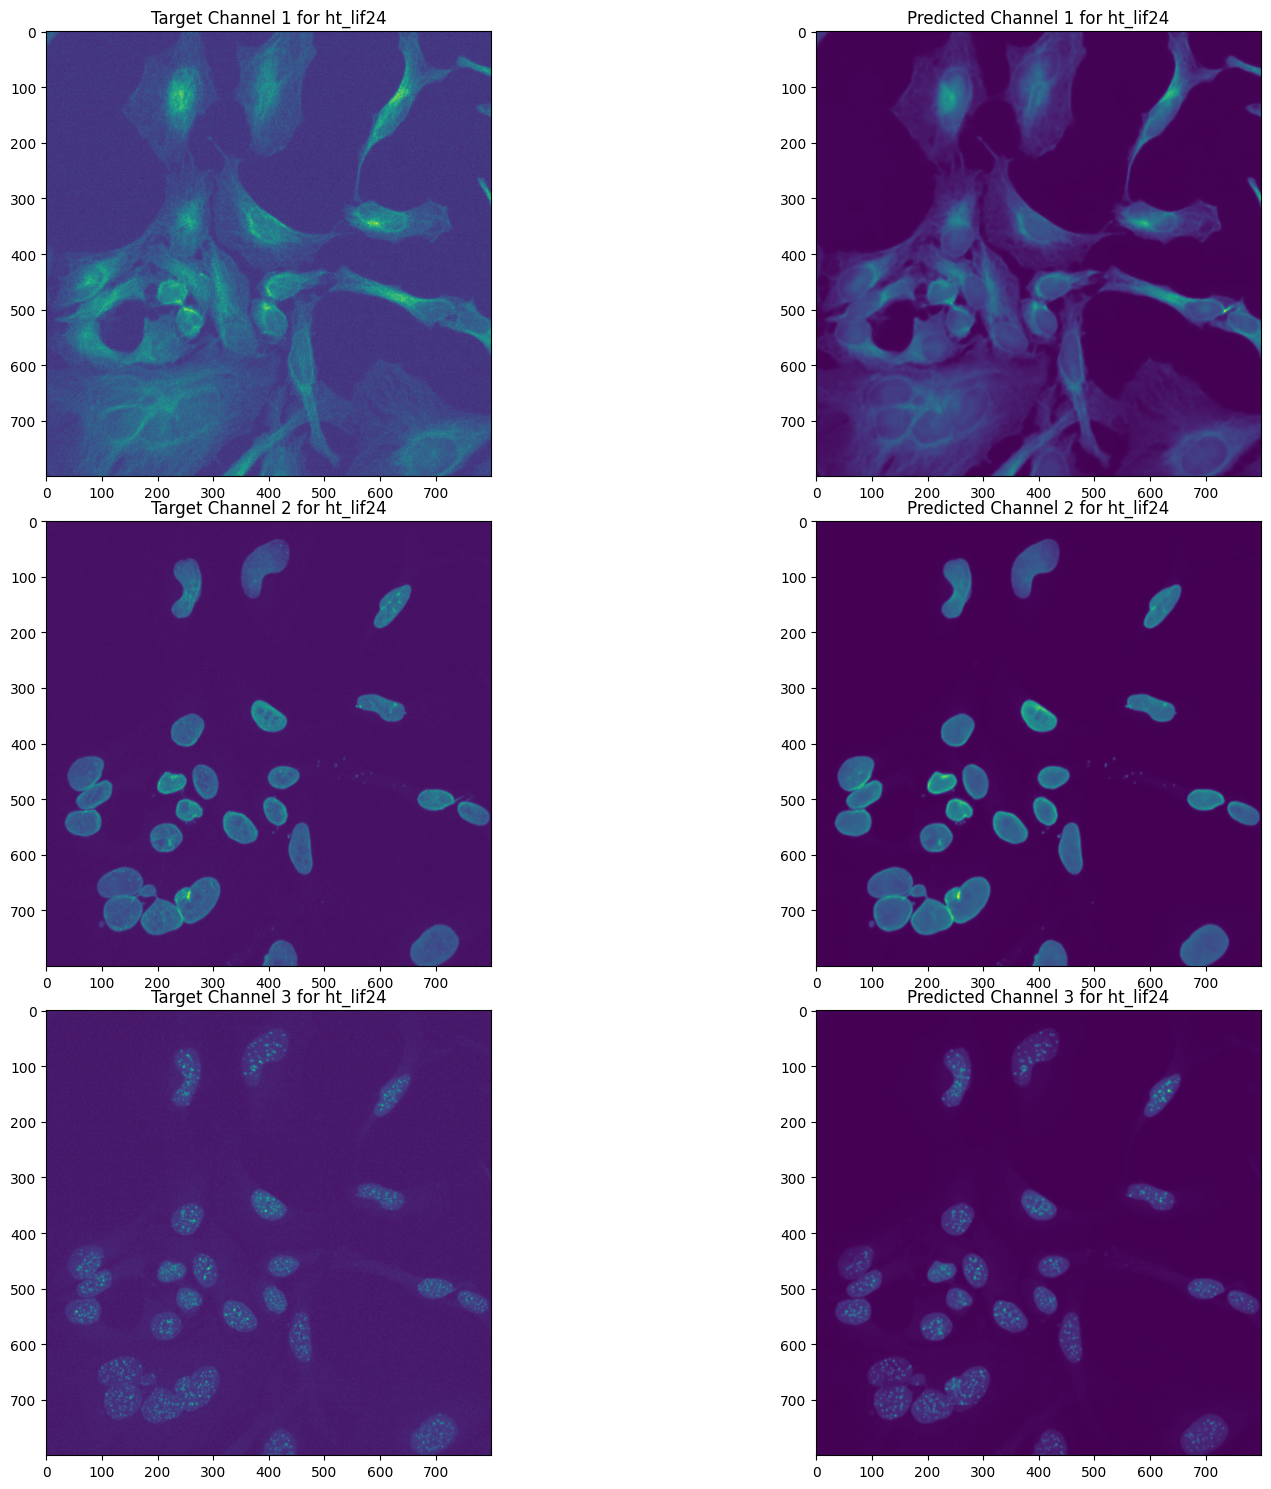

In [22]:
# One random target vs predicted image (patch of shape [sz x sz])
ncols = target.shape[-1]
_, ax = plt.subplots(figsize=(ncols * 5, 3 * 5), nrows=3, ncols=2)
img_idx = 10
sz = 800
hs = np.random.randint(target.shape[1] - sz)
ws = np.random.randint(target.shape[2] - sz)
for i in range(ncols):
    ax[i, 0].set_title(f"Target Channel {i+1} for {filename_idx}")
    ax[i, 0].imshow(target[0, hs : hs + sz, ws : ws + sz, i])
    ax[i, 1].set_title(f"Predicted Channel {i+1} for {filename_idx}")
    ax[i, 1].imshow(predictions[0, hs : hs + sz, ws : ws + sz, i])

plt.tight_layout()
plt.subplots_adjust(wspace=0.1, hspace=0.1)

7


/home/ashesh.ashesh/mambaforge/envs/microSplit/lib/python3.9/site-packages/careamics/lvae_training/eval_utils.py:421: UserWarning: Overwriting the cmap 'shiftedcmap' that was already in the registry.
  matplotlib.colormaps.register(cmap=newcmap, force=True)


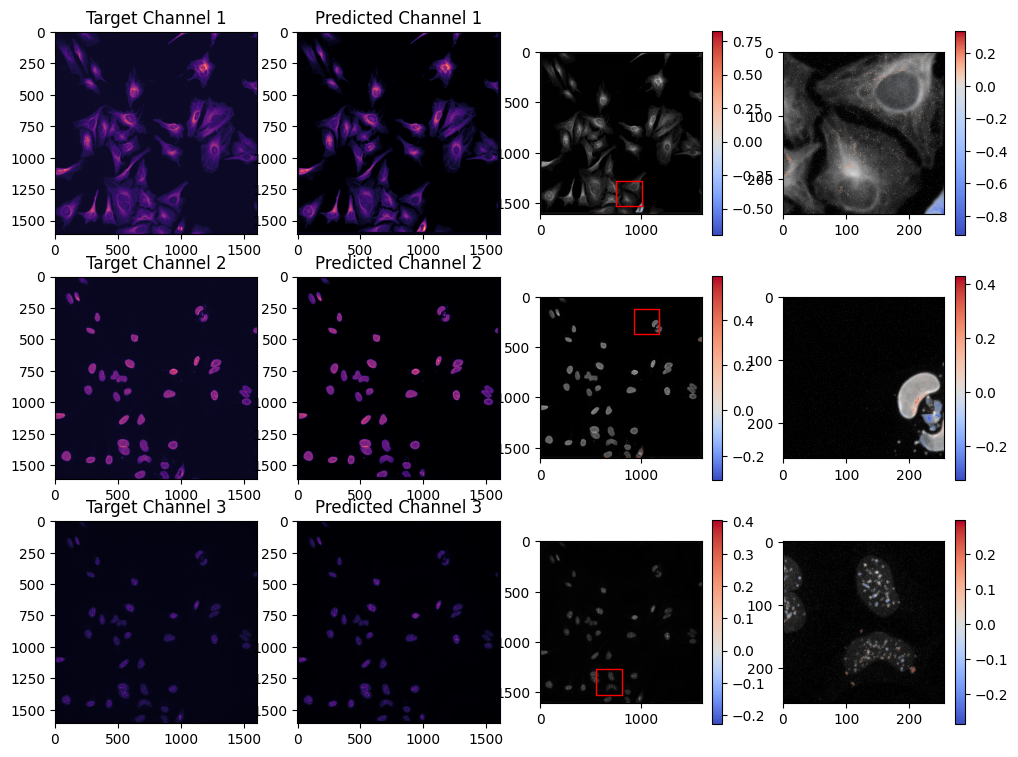

In [23]:
nrows = predictions.shape[-1]
img_sz = 3
_, ax = plt.subplots(figsize=(4 * img_sz, nrows * img_sz), ncols=4, nrows=nrows)
idx = np.random.randint(len(predictions))
print(idx)
for ch_id in range(nrows):
    ax[ch_id, 0].set_title(f"Target Channel {ch_id+1}")
    ax[ch_id, 0].imshow(target_normalized[idx, ..., ch_id], cmap="magma")
    ax[ch_id, 1].set_title(f"Predicted Channel {ch_id+1}")
    ax[ch_id, 1].imshow(predictions[idx, :, :, ch_id], cmap="magma")
    plot_error(
        target_normalized[idx, ..., ch_id],
        predictions[idx, :, :, ch_id],
        cmap=mpl.cm.coolwarm,
        ax=ax[ch_id, 2],
        max_val=None,
    )

    cropsz = 256
    h_s = np.random.randint(0, target_normalized.shape[1] - cropsz)
    h_e = h_s + cropsz
    w_s = np.random.randint(0, target_normalized.shape[2] - cropsz)
    w_e = w_s + cropsz

    plot_error(
        target_normalized[idx, h_s:h_e, w_s:w_e, ch_id],
        predictions[idx, h_s:h_e, w_s:w_e, ch_id],
        cmap=mpl.cm.coolwarm,
        ax=ax[ch_id, 3],
        max_val=None,
    )

    # Add rectangle to the region
    rect = patches.Rectangle(
        (w_s, h_s), w_e - w_s, h_e - h_s, linewidth=1, edgecolor="r", facecolor="none"
    )
    ax[ch_id, 2].add_patch(rect)

In [24]:
rmse_arr = []
psnr_arr = []
rinv_psnr_arr = []
ssim_arr = []
for ch_id in range(predictions.shape[-1]):
    rmse = np.sqrt(
        ((predictions[..., ch_id] - target_normalized[..., ch_id]) ** 2)
        .reshape(len(predictions), -1)
        .mean(axis=1)
    )
    rmse_arr.append(rmse)
    rinv_psnr = avg_range_invariant_psnr(
        target_normalized[..., ch_id].copy(), predictions[..., ch_id].copy()
    )
    ssim_mean, ssim_std = avg_ssim(target[...,ch_id], pred_unnormalized[ch_id])
    rinv_psnr_arr.append(rinv_psnr)
    ssim_arr.append((ssim_mean,ssim_std))

In [25]:
print("RangeInvPSNR: ", " <--> ".join([str(x) for x in rinv_psnr_arr]))
print("MicroSSIM: ", " <--> ".join([f"{round(x,3)}±{round(y,4)}" for (x, y) in ssim_arr]))

RangeInvPSNR:  34.023170230022096 <--> 36.4718573288418 <--> 39.14169667465598
MicroSSIM:  0.832±0.0963 <--> 0.929±0.0216 <--> 0.929±0.0479


### Save results for calibration

In [26]:
os.makedirs("predictions", exist_ok=True)
# get the filename without the path and extension
filename = 'ht_lif24'
tifffile.imwrite(
    f"predictions/prediction_{filename}.tif", stitched_predictions[filename]
)
tifffile.imwrite(f"predictions/std_{filename}.tif", stitched_stds[filename])